In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid
import glob
import pickle

# ML Imports
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

import shap

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [64]:
PROCESSED_DIR = "data/processed"

## 1. Load Data
---

In [65]:
# Raw Data
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_with_ccp_03.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

In [66]:
# Load top-performing imputed dataset
Xi_mice = pd.read_csv("data/imputed/full_dataset/mice_qvars_02.tsv", sep="\t")
Xi_mice = Xi_mice.loc[Xi_mice.join(data_df['fna3_cluster_n']).dropna(subset='fna3_cluster_n').index]

# Full dataset
X = pd.DataFrame(StandardScaler().fit_transform(Xi_mice.values), index=Xi_mice.index, columns=Xi_mice.columns)
y = data_df.loc[Xi_mice.index, 'fna3_cluster_n'].map({'Low':0,'Intermediate':1, 'High': 2})

# Drop due to high missingness
to_drop = ["Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education","Abdominal fat pad CR staining", "Bone marrow CR staining"]

# Create filtered dataset (for complete categoricals)
X_filt = utils.data_formatter(
    X.join(data_df.loc[Xi_mice.index, amyloid.catvars]).drop(columns=to_drop).dropna(),
    verbose=True
)
y_filt = data_df.loc[X_filt.index, 'fna3_cluster_n'].map({'Low':0,'Intermediate':1, 'High': 2})


Using 29 quantitative variables.
Using 33 categorical variables.
Total samples x feaures (one-hot encoded): (1599 x 71)


## 2. Modeling
---

* `hyperopt` ran for all classification models (MLP, random forest, naive bayes, KNN, XGBoost, SVC, Tree) with `05b_pred_hyperopt.py`
* Results loaded here and cross validation metrics computed

In [5]:
NJOBS = -1
RANDOM_STATE = 122
CV=5

In [6]:
# Load models
hyperopt_estimators = dict()
hyperopt_models = dict()

for filename in glob.glob("data/subgroup_prediction/*.pkl"):
    with open(filename, "rb") as file:
        _name = filename.split("/")[-1].split(".pkl")[0].split("hyperopt_")[1]
        hyperopt_estimators[_name] = pickle.load(file)
        hyperopt_models[_name] = hyperopt_estimators[_name].best_model()['learner']

In [7]:
for mod in hyperopt_models.keys():
    if "categ" in mod:
        hyperopt_models[mod].fit(X_filt, y_filt)
    else:
        hyperopt_models[mod].fit(X, y)

[14:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

[14:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


## 3. Feature Importance
---

In [8]:
shap_values = dict()

for filename in glob.glob("data/subgroup_prediction/shap/*.pkl"):
    with open(filename, "rb") as file:
        _name = filename.split("/")[-1].split(".pkl")[0].split("shap_values_")[1]
        shap_values[_name] = pickle.load(file)
        shap.plots.beeswarm(shap_values[_name], max_display=20, alpha=0.5, show=False)
        plt.savefig("figures/shap_{}.pdf".format(_name), dpi=200, bbox_inches="tight")
        plt.close()

In [80]:
# Plots for top performing models
shap.plots.beeswarm(shap_values['xgb'][y.values==0], max_display=20, alpha=0.5, show=False)
plt.savefig("figures/shap_xgb_low.pdf", dpi=200, bbox_inches="tight")
plt.close()

shap.plots.beeswarm(shap_values['xgb'][y.values==1], max_display=20, alpha=0.5, show=False)
plt.savefig("figures/shap_xgb_int.pdf", dpi=200, bbox_inches="tight")
plt.close()

shap.plots.beeswarm(shap_values['xgb'][y.values==2], max_display=20, alpha=0.5, show=False)
plt.savefig("figures/shap_xgb_high.pdf", dpi=200, bbox_inches="tight")
plt.close()

# Plots for top performing models
shap.plots.beeswarm(shap_values['categ_rf'][y_filt.values==0], max_display=20, alpha=0.5, show=False)
plt.savefig("figures/shap_categ_rf_low.pdf", dpi=200, bbox_inches="tight")
plt.close()

shap.plots.beeswarm(shap_values['categ_rf'][y_filt.values==1], max_display=20, alpha=0.5, show=False)
plt.savefig("figures/shap_categ_rf_int.pdf", dpi=200, bbox_inches="tight")
plt.close()

shap.plots.beeswarm(shap_values['categ_rf'][y_filt.values==2], max_display=20, alpha=0.5, show=False)
plt.savefig("figures/shap_categ_rf_high.pdf", dpi=200, bbox_inches="tight")
plt.close()

In [9]:
amyloid.ddict_unclean['eGFR'] = 'eGFR'
amyloid.ddict_unclean['X24_hr_UTP'] = '24h UTP'

shap_values['xgb'].feature_names = [amyloid.ddict_unclean[x] for x in shap_values['xgb'].feature_names]

In [10]:
# Figure 5
shap.plots.heatmap(
    shap_values['xgb'], 
    max_display=30, 
    instance_order=X.join(y).reset_index().sort_values('fna3_cluster_n').index,
    show=False
)

plt.savefig("figures/shap_heatmap_xgb.pdf", dpi=200, bbox_inches="tight")
plt.close()


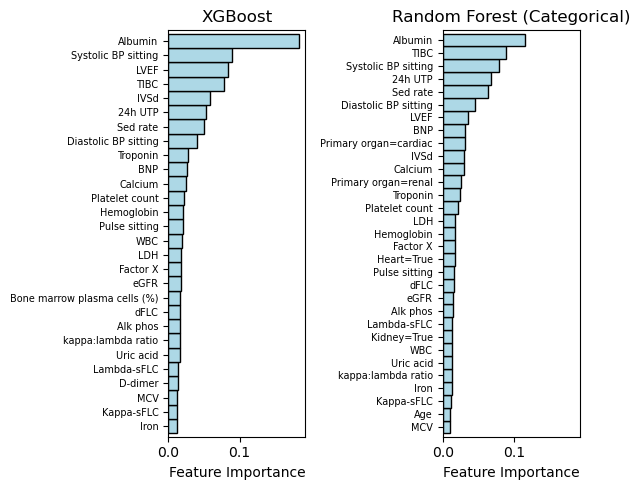

In [12]:
fig,axes = plt.subplots(1,2,figsize=(6,5), sharex=True)

xgb_features_df = plot.plot_feature_importance(hyperopt_models['xgb'], ax=axes[0])
categ_rf_features_df = plot.plot_feature_importance(hyperopt_models['categ_rf'], ax=axes[1])

axes[0].set_title("XGBoost")
axes[1].set_title("Random Forest (Categorical)")

plt.tight_layout()
plt.savefig("figures/feature_importances_mods.pdf", dpi=200, bbox_inches='tight')

## 4. Abbreivated Model
---

In [39]:
# Including Troponin and BNP
features_with_echo = list(xgb_features_df[xgb_features_df["importance"]>np.mean(xgb_features_df["importance"])].index) + ['Troponin','BNP']
features_no_echo = list(np.setdiff1d(features_with_echo,["IVSd","LVEF"]))

features_no_echo, features_with_echo

(['Albumin',
  'BNP',
  'Diastolic_BP_sitting',
  'Sed_rate',
  'Systolic_BP_sitting',
  'TIBC',
  'Troponin',
  'X24_hr_UTP'],
 ['IVSd',
  'LVEF',
  'Sed_rate',
  'X24_hr_UTP',
  'Albumin',
  'TIBC',
  'Systolic_BP_sitting',
  'Diastolic_BP_sitting',
  'Troponin',
  'BNP'])

In [32]:
Xi_mice[features_with_echo].to_csv("data/processed/Xi_abbr_echo.tsv", sep="\t")
Xi_mice[features_no_echo].to_csv("data/processed/Xi_abbr.tsv", sep="\t")

In [44]:
shap_abbr_values = dict()

for filename in glob.glob("data/subgroup_prediction_abbr/shap/*.pkl"):
    with open(filename, "rb") as file:
        _name = filename.split("/")[-1].split(".pkl")[0].split("shap_values_")[1]
        shap_values[_name] = pickle.load(file)
        shap.plots.beeswarm(shap_values[_name], max_display=20, alpha=0.5, show=False)
        plt.savefig("figures/shap_abbr_{}.pdf".format(_name), dpi=200, bbox_inches="tight")
        plt.close()